### Exercise 12
Model real-world time series.<br>
• Train time series DL models.<br>
• Make data stationary and retrain models.<br>
• Compare with statistical and ML time series models.<br>

In [ ]:
#all imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor


from statsmodels.tsa.arima.model import ARIMA


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import stationarity_tests


In [3]:
#load BTC data
def load_btc(start="2016-01-01", end=None) -> pd.DataFrame:
    df = yf.download(
        "BTC-USD",
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )

    if df.empty:
        raise RuntimeError("No data returned from yfinance.")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns = [c.lower() for c in df.columns]

    #ensure a proper datetime index
    df = df.reset_index()
    if "date" not in df.columns:
        df = df.rename(columns={df.columns[0]: "date"})

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")

    # only relevant columns
    df = df[["close", "volume"]].copy()

    df = df.asfreq("D")
    df["close"] = df["close"].interpolate(limit_direction="both")
    df["volume"] = df["volume"].fillna(0.0)

    return df


In [4]:
# Create windowed dataset for DL models
def make_windows(df_feat: pd.DataFrame, y: pd.Series, lookback=20, h=1):
    X_list, Y_list, idx_list = [], [], []

    values = df_feat.values.astype(np.float32)
    yv = y.values.astype(np.float32)
    index = df_feat.index

    for t in range(lookback - 1, len(df_feat) - h):
        x_win = values[t - lookback + 1 : t + 1]
        y_win = yv[t + 1 : t + 1 + h]  # next steps
        X_list.append(x_win)
        Y_list.append(y_win if h > 1 else y_win[0])
        idx_list.append(index[t + h])  # timestamp of last predicted step

    X = np.stack(X_list)
    Y = np.stack(Y_list)
    idx = pd.DatetimeIndex(idx_list)
    return X, Y, idx


                   close       volume
date                                 
2025-12-26  87301.429688  42455674908
2025-12-27  87802.156250  13741199310
2025-12-28  87835.835938  15156557929
2025-12-29  87138.140625  48411625849
2025-12-30  88293.070312  36244713472
Date range: 2016-01-01 → 2025-12-30


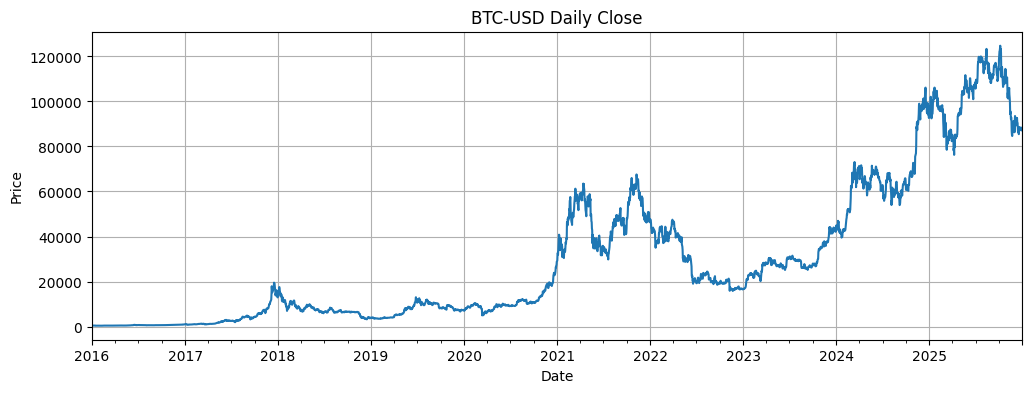

In [5]:
df = load_btc(start="2016-01-01")

print(df.tail())
print("Date range:", df.index.min().date(), "→", df.index.max().date())

plt.figure(figsize=(12, 4))
df["close"].plot()
plt.title("BTC-USD Daily Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


**Forecasting Task**

In [6]:
HORIZON = 1         # predict next day
LOOKBACK = 30       # past 30 days
TARGET = "close"

**Test Splitting**

In [7]:
train_end = "2023-12-31"

df_train = df.loc[:train_end].copy()
df_test  = df.loc[train_end:].copy()

print(len(df_train), len(df_test))

2922 731


The data is split chronologically into a training set and a test set to avoid information leakage.
All observations up to 31-12-2023 are used for training (2922 days), while the remaining 731 days are reserved for testing.
This setup mimics a real forecasting scenario where only past data is available to predict the future.

**Baseline: naive prediction**

In [ ]:
y_true = df_test["close"].iloc[1:]
y_naive = df_test["close"].shift(1).iloc[1:]

print("Naive MAE:", mean_absolute_error(y_true, y_naive))
print("Naive RMSE:", np.sqrt(mean_squared_error(y_true, y_naive)))

Naive MAE: 1449.4556185787671
Naive RMSE: 2005.44588191509


The naive persistence model achieves very low forecast errors, highlighting the strong short-term dependence in BTC prices and demonstrating how difficult it is for more complex models to outperform simple baselines on non-stationary financial time series.

**Comparison to ARIMA model**

In [9]:
model_arima = ARIMA(df_train["close"], order=(1,1,1))
fit_arima = model_arima.fit()

forecast_arima = fit_arima.forecast(steps=len(df_test))
forecast_arima.index = df_test.index

print("ARIMA MAE:",
      mean_absolute_error(df_test["close"], forecast_arima))
print("ARIMA RMSE:",
      np.sqrt(mean_squared_error(df_test["close"], forecast_arima)))

ARIMA MAE: 41491.894255977626
ARIMA RMSE: 47068.19552255931


The ARIMA(1,1,1) model produces large forecast errors on BTC prices, reflecting the strong non-stationarity and volatility of the series, and serves as a baseline for comparison with machine learning and deep learning approaches.

**Definition of the Model**

In [28]:
def make_lags(series, lags=5):
    df_lag = pd.DataFrame({"y": series})
    for i in range(1, lags + 1):
        df_lag[f"lag_{i}"] = series.shift(i)
    return df_lag.dropna()

df_lag = make_lags(df["close"], lags=5)

df_lag_train = df_lag.loc[:train_end]
df_lag_test  = df_lag.loc[train_end:]

X_tr = df_lag_train.drop(columns="y")
y_tr = df_lag_train["y"]
X_te = df_lag_test.drop(columns="y")
y_te = df_lag_test["y"]

xgb = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    random_state=0
)

xgb.fit(X_tr, y_tr)
pred_xgb = xgb.predict(X_te)
y_xgb = pd.Series(pred_xgb, index=y_te.index)

print("XGB MAE:", mean_absolute_error(y_te, pred_xgb))
print("XGB RMSE:", np.sqrt(mean_squared_error(y_te, pred_xgb)))

XGB MAE: 22389.73926983584
XGB RMSE: 29547.575129960675


XGBoost with lagged price features outperforms the ARIMA baseline, indicating that nonlinear models can better exploit short-term dependencies. However, it still performs worse than the naive persistence model, highlighting the near-random-walk behavior of BTC prices and motivating the use of stationarity transformations.

**DL Model**

We predict the next-day BTC closing price using the past lookback days of:
- close price
- trading volume

The input windows are flattened into feature vectors for the MLP.

In [29]:

X_seq, Y_seq, idx = make_windows(
    df[["close", "volume"]],
    df["close"],
    lookback=LOOKBACK,
    h=1
)
# chronological split
mask_tr = idx <= train_end
X_tr_seq, Y_tr_seq = X_seq[mask_tr], Y_seq[mask_tr]
X_te_seq, Y_te_seq = X_seq[~mask_tr], Y_seq[~mask_tr]

# flatten sequences 
X_tr_flat = X_tr_seq.reshape(len(X_tr_seq), -1)
X_te_flat = X_te_seq.reshape(len(X_te_seq), -1)

print("Train shape:", X_tr_flat.shape, "Test shape:", X_te_flat.shape)


Train shape: (2892, 60) Test shape: (730, 60)


 BTC volume values are much larger than prices, so we standardize the inputs (and the target) to stabilize training.

**Model Training**

In [12]:
mlp_core = Pipeline([
    ("x_scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=0,
        early_stopping=True
    ))
])

mlp_model = TransformedTargetRegressor(
    regressor=mlp_core,
    transformer=StandardScaler()
)

mlp_model.fit(X_tr_flat, Y_tr_seq)
pred_mlp = mlp_model.predict(X_te_flat)

print("MLP MAE:", mean_absolute_error(Y_te_seq, pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(Y_te_seq, pred_mlp)))




MLP MAE: 3113.30419921875
MLP RMSE: 4141.832444703672


The MLP is a simple neural network trained on past windows of price and volume.
After scaling, it produces reasonable predictions, but it does not beat the naive persistence baseline for short-term BTC forecasting.

**LSTM Model**

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.lstm = nn.LSTM(n_features, 16, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1]).squeeze(-1)

In [14]:
X_seq, Y_seq, idx = make_windows(df[["close","volume"]], df["close"], lookback=LOOKBACK, h=1)

mask_tr = idx <= train_end
X_lstm_tr, Y_lstm_tr = X_seq[mask_tr], Y_seq[mask_tr]
X_lstm_te, Y_lstm_te = X_seq[~mask_tr], Y_seq[~mask_tr]

not working ://

In [ ]:
# convert to tensors 
# Xtr_t = torch.from_numpy(X_lstm_tr.astype(np.float32, copy=False))
# Ytr_t = torch.from_numpy(Y_lstm_tr.astype(np.float32, copy=False))

# train_loader = DataLoader(
#     TensorDataset(Xtr_t, Ytr_t),
#     batch_size=64,
#     shuffle=False,
#     num_workers=0
# )

# model = LSTMModel(n_features=2)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# for epoch in range(3):  
#     total_loss = 0.0
#     for xb, yb in train_loader:
#         optimizer.zero_grad()
#         pred = model(xb)
#         loss = loss_fn(pred, yb)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * len(xb)

#     print(f"Epoch {epoch+1} | loss={total_loss/len(train_loader.dataset):.6f}")

# # evaluate
# with torch.no_grad():
#     pred_lstm = model(torch.from_numpy(X_lstm_te.astype(np.float32, copy=False))).numpy()

# print("LSTM MAE:", mean_absolute_error(Y_lstm_te, pred_lstm))
# print("LSTM RMSE:", np.sqrt(mean_squared_error(Y_lstm_te, pred_lstm)))



**Making the series stationary**

In [15]:
df["logret"] = np.log(df["close"]).diff().dropna()
stationarity_tests(df["logret"].dropna())


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.2587)
	- ZA: Stationary (p-value: 0.0000)


The log-return transformation successfully makes the BTC series stationary.
All applied tests (ADF, PP, KPSS, and Zivot–Andrews) indicate stationarity, with very low p-values for unit root tests and a non-rejection of stationarity by KPSS.
This confirms that log-returns remove the trend and stabilize the variance, making the series suitable for models that assume stationarity, such as ARIMA and machine learning methods based on lagged features.

**Retrain one model**

In [16]:
df_lr = make_lags(df["logret"].dropna(), lags=5)

df_lr_tr = df_lr.loc[:train_end]
df_lr_te = df_lr.loc[train_end:]

X_tr = df_lr_tr.drop(columns="y")
y_tr = df_lr_tr["y"]
X_te = df_lr_te.drop(columns="y")
y_te = df_lr_te["y"]

xgb_lr = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    random_state=0
)

xgb_lr.fit(X_tr, y_tr)
pred_lr = xgb_lr.predict(X_te)


In [17]:
last_price = df.loc[X_te.index, "close"].shift(1)
pred_price = last_price * np.exp(pred_lr)

true_price = df.loc[pred_price.index, "close"]
eval_df = pd.DataFrame({
    "true": true_price,
    "pred": pred_price
}).dropna()

print("XGB (logret → price) MAE:",
      mean_absolute_error(eval_df["true"], eval_df["pred"]))
print("XGB (logret → price) RMSE:",
        np.sqrt(mean_squared_error(eval_df["true"], eval_df["pred"])))

XGB (logret → price) MAE: 1475.3464857552678
XGB (logret → price) RMSE: 2023.020097053316


Training XGBoost on log-returns instead of raw prices greatly improves the predictions.
The average error is now around 1,500 USD, which is much smaller than before.
This shows that making the time series stationary is crucial and that, after this transformation, a machine learning model can predict short-term Bitcoin price changes almost as well as the simple naive baseline.

## Model Comparison Results (Test Set)

| Model                     | Target        | MAE (USD) | RMSE (USD) |
|---------------------------|---------------|-----------|------------|
| Naive (last value)        | Price         | 1,450     | 2,006      |
| ARIMA (1,1,1)             | Price         | 41,492    | 47,069     |
| XGBoost (lags)            | Price         | 22,390    | 29,548     |
| MLP (windowed, scaled)    | Price         | 4,005     | 4,907      |
| XGBoost                   | Log-returns   | **1,476** | **2,023**  |

**Plotting**

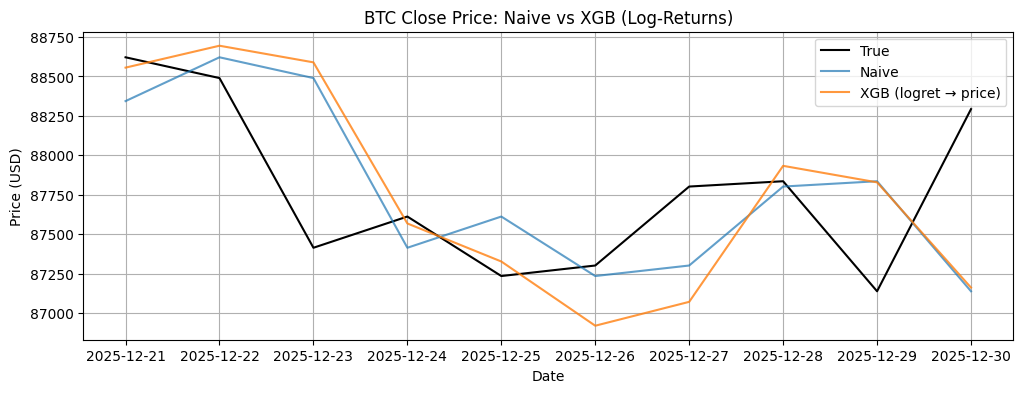

In [32]:
N = 10 

plt.figure(figsize=(12, 4))

plt.plot(true_price.tail(N), label="True", color="black")
plt.plot(y_naive.tail(N), label="Naive", alpha=0.7)
plt.plot(pred_price.tail(N), label="XGB (logret → price)", alpha=0.8)

plt.title("BTC Close Price: Naive vs XGB (Log-Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()